In [1]:
"""
Core dependencies for LLM evaluation framework
Including:
- Basic data processing and statistical libraries
- Google Cloud authentication
- LangChain components for retrieval and embeddings 
- Ragas evaluation metrics
- PDF processing utilities
"""

# Standard libraries for data processing and analysis
import os
import time
import numpy as np
from scipy import stats
from typing import List, Dict, Any
from tqdm.notebook import tqdm
import pandas as pd
from os import stat
import chromadb

# Google Cloud authentication utilities
from google.auth import load_credentials_from_file

# LangChain components for retrieval and LLM integration
from langchain_community.retrievers import BM25Retriever
from langchain_core.documents import Document
from langchain_google_vertexai import VertexAI, VertexAIEmbeddings
from langchain_chroma import Chroma
from langchain_openai import ChatOpenAI

# Ragas evaluation metrics and utilities
from ragas.metrics import LLMContextRecall, Faithfulness, FactualCorrectness, SemanticSimilarity
from ragas import evaluate
from ragas.llms import LangchainLLMWrapper
from ragas.embeddings import LangchainEmbeddingsWrapper
from ragas.run_config import RunConfig
from ragas import EvaluationDataset

# Type hints for better code clarity
from typing import cast as t
from langchain_core.outputs import LLMResult, ChatGeneration
from langchain_core.messages import BaseMessage

# Custom evaluation metrics
from llm_evaluation.evaluate_fact_beta import FactualCorrectnessReviseBeta

# PDF document processing
import fitz  # PyMuPDF for PDF extraction

In [2]:
# Load Google Cloud credentials and project configuration
# Replace with your own credentials file
credentials, project_id = load_credentials_from_file(
    "path/to/your/auth.json"
)
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "path/to/your/auth.json"

In [1]:
# Configure OpenAI API authentication
import os 
os.environ["OPENAI_API_KEY"] = "<YOUR_OPENAI_API_KEY>" 

In [4]:
class CustomHybridRetriever:
    """
    A hybrid retrieval system that combines vector-based and BM25 retrievers
    
    Implements a weighted combination of semantic search and keyword-based retrieval
    to leverage the strengths of both approaches
    """
    def __init__(self, vector_retriever, bm25_retriever, weight_vector=0.5, k=4):
        """
        Initialize hybrid retriever with configurable weights and parameters
        
        Args:
            vector_retriever: Semantic vector-based retriever
            bm25_retriever: Keyword-based BM25 retriever
            weight_vector: Weight for vector scores (0-1)
            k: Number of documents to return
        """
        self.vector_retriever = vector_retriever
        self.bm25_retriever = bm25_retriever
        self.weight_vector = weight_vector
        self.k = k
        
    def invoke(self, query: str) -> List[Document]:
        """
        Retrieve and combine results from both retrievers
        
        Process:
        1. Get documents from both retrievers
        2. Normalize relevance scores 
        3. Combine scores using weighted average
        4. Return top-k documents
        
        Args:
            query: Search query string
            
        Returns:
            List of most relevant documents with combined scores
        """
        try:
            vector_docs = self.vector_retriever.invoke(query)
            bm25_docs = self.bm25_retriever.invoke(query)
            
            print(f"Vector retriever returned {len(vector_docs)} docs")
            print(f"BM25 retriever returned {len(bm25_docs)} docs")
            
            doc_scores = {}
            
            max_vector_score = max((doc.metadata.get('score', 0.0) for doc in vector_docs), default=1.0)
            for doc in vector_docs:
                content = doc.page_content
                score = doc.metadata.get('score', 0.5)
                # Normalize score
                normalized_score = score / max_vector_score if max_vector_score > 0 else score
                doc_scores[content] = {
                    'vector_score': normalized_score,
                    'bm25_score': 0.0,
                    'doc': doc
                }
            
            # Normalize scores for BM25 docs
            max_bm25_score = max((doc.metadata.get('score', 0.0) for doc in bm25_docs), default=1.0)
            for doc in bm25_docs:
                content = doc.page_content
                score = doc.metadata.get('score', 0.5)
                normalized_score = score / max_bm25_score if max_bm25_score > 0 else score
                
                if content in doc_scores:
                    doc_scores[content]['bm25_score'] = normalized_score
                else:
                    doc_scores[content] = {
                        'vector_score': 0.0,
                        'bm25_score': normalized_score,
                        'doc': doc
                    }
            
            # Calculate combined scores
            final_scores = []
            for content, scores in doc_scores.items():
                combined_score = (
                    self.weight_vector * scores['vector_score'] +
                    (1 - self.weight_vector) * scores['bm25_score']
                )
                final_scores.append((combined_score, scores['doc']))
            
            # Sort by combined score and get top k
            final_docs = [
                doc for _, doc in sorted(final_scores, key=lambda x: x[0], reverse=True)[:self.k]
            ]
            
            # Add combined scores to metadata
            for i, doc in enumerate(final_docs):
                doc.metadata['hybrid_score'] = final_scores[i][0]
            
            print(f"Hybrid retriever returning {len(final_docs)} docs")
            if final_docs:
                print(f"Top document scores: {[doc.metadata.get('hybrid_score', 0.0) for doc in final_docs[:3]]}")
            
            return final_docs
            
        except Exception as e:
            print(f"Error in hybrid retriever: {str(e)}")
            import traceback
            traceback.print_exc()
            return []

In [5]:
def extract_text_from_pdf(pdf_path: str) -> List[Document]:
    """
    Extract text content and metadata from PDF documents
    
    Process:
    1. Opens PDF file using PyMuPDF
    2. Extracts text from each page
    3. Creates Document objects with content and metadata
    
    Args:
        pdf_path: Path to the PDF file to process
        
    Returns:
        List[Document]: Collection of Document objects containing:
            - page_content: Extracted text from each page
            - metadata: Source file, page number, and total pages
    """
    documents = []
    try:
        # Open PDF document
        pdf_document = fitz.open(pdf_path)

        # Process each page
        for page_num in range(len(pdf_document)):
            page = pdf_document[page_num]
            text = page.get_text("text")

            # Create document if page has content
            if text.strip():
                metadata = {
                    "source": pdf_path,
                    "page": page_num + 1,
                    "total_pages": len(pdf_document)
                }
                documents.append(Document(page_content=text, metadata=metadata))
        pdf_document.close()
    except Exception as e:
        print(f"Error processing {pdf_path}: {str(e)}")
    return documents

In [6]:
def load_pdfs_from_directory(directory_path: str) -> List[Document]:
    """
    Load all PDF documents from a specified directory
    
    Args:
        directory_path: Path to directory containing PDF files
        
    Returns:
        List of Document objects from all PDFs in directory
    """
    documents = []
    with tqdm(os.listdir(directory_path), desc="Loading PDFs") as pbar:
        for filename in pbar:
            if filename.lower().endswith('.pdf'):
                file_path = os.path.join(directory_path, filename)
                pbar.set_postfix(file=filename)
                documents.extend(extract_text_from_pdf(file_path))
    return documents

In [7]:
def custom_is_finished_parser(response: LLMResult):
    """
    Custom parser to determine if LLM generation is complete
    
    Checks completion status through:
    1. Generation info metadata
    2. Chat message response metadata
    3. Default completion assumption
    
    Args:
        response: LLM generation result object
        
    Returns:
        bool: True if all generations are complete
    """
    is_finished_list = []
    for g in response.flatten():
        resp = g.generations[0][0]

        # Check generation info metadata
        if resp.generation_info is not None:
            if resp.generation_info.get("finish_reason") is not None:
                is_finished_list.append(
                    resp.generation_info.get("finish_reason") == "STOP"
                )

        # Check chat message response metadata
        elif (
            isinstance(resp, ChatGeneration)
            and t.cast(ChatGeneration, resp).message is not None
        ):
            resp_message: BaseMessage = t.cast(ChatGeneration, resp).message
            if resp_message.response_metadata.get("finish_reason") is not None:
                is_finished_list.append(
                    resp_message.response_metadata.get("finish_reason") == "STOP"
                )

        # Default to complete if no metadata available
        else:
            is_finished_list.append(True)
    return all(is_finished_list)

In [8]:
class RetrievalEvaluator:
    """
    Evaluation framework for comparing different retrieval methods
    
    Implements comprehensive evaluation of vector, BM25, and hybrid retrieval approaches
    using multiple metrics and statistical analysis
    """
    def __init__(self, data_dir: str, persist_dir: str):
        """
        Initialize evaluation framework with models and retrievers
        
        Args:
            data_dir: Directory containing source documents
            persist_dir: Directory for storing vector indices
        """
        self.data_dir = data_dir
        self.persist_dir = persist_dir
        
        # Initialize embeddings
        self.embeddings = VertexAIEmbeddings(
            model_name="textembedding-gecko",
            project=project_id,
            credentials=credentials,
            location="us-central1"
        )
        
        # Initialize LLMs
        self.eval_llm = ChatOpenAI(
            model="gpt-3.5-turbo",
            temperature=0.1
        )
        
        self.exp_llm = VertexAI(
            model_name="gemini-1.0-pro",
            temperature=0.1,
            max_output_tokens=8192,
            project=project_id,
            credentials=credentials
        )
        
        print("Loading documents...")
        self.documents = load_pdfs_from_directory(data_dir)
        print(f"Loaded {len(self.documents)} documents")
        
        print("Initializing retrievers...")
        self.vector_retriever = self._init_vector_retriever()
        self.bm25_retriever = self._init_bm25_retriever()
        self.hybrid_retriever = self._init_hybrid_retriever()
        print("Initialization complete")

    def _init_vector_retriever(self):
        """
        Initialize vector-based retrieval system
        
        Process:
        1. Clear existing vector store
        2. Filter valid documents
        3. Create new vector embeddings
        4. Configure retriever parameters
        
        Returns:
            Configured vector retriever or None if initialization fails
        """
        print("Initializing vector retriever...")
        try:
            if os.path.exists(f"{self.persist_dir}/vector"):
                import shutil
                shutil.rmtree(f"{self.persist_dir}/vector")
                print("Cleared existing vector store")

            print("Creating new vector store...")

            valid_docs = [doc for doc in self.documents if doc.page_content.strip()]
            print(f"Found {len(valid_docs)} valid documents")

            vectorstore = Chroma.from_documents(
                documents=valid_docs,
                embedding=self.embeddings,
                persist_directory=f"{self.persist_dir}/vector"
            )
            print(f"Created vector store with {vectorstore._collection.count()} documents")

            retriever = vectorstore.as_retriever(
                search_kwargs={
                    "k": 4,
                }
            )
            
            return retriever
            
        except Exception as e:
            print(f"Error initializing vector retriever: {str(e)}")
            import traceback
            traceback.print_exc()
            return None

    def _init_bm25_retriever(self):
        """
        Initialize BM25 keyword-based retriever
        
        Process:
        1. Preprocess documents
        2. Configure BM25 parameters
        3. Validate retriever functionality
        
        Returns:
            Configured BM25 retriever or None if initialization fails
        """
        print("Initializing BM25 retriever...")
        try:
            processed_docs = []
            for doc in self.documents:
                if doc.page_content.strip():  
                    metadata = doc.metadata.copy() if hasattr(doc, 'metadata') else {}
                    processed_docs.append(Document(
                        page_content=doc.page_content,
                        metadata=metadata
                    ))
            
            print(f"Processing {len(processed_docs)} documents for BM25")
            

            retriever = BM25Retriever.from_documents(
                documents=processed_docs,
                preprocess_func=lambda text: text.split(), 
                k=4
            )
            
            test_query = "What is instruction tuning?"
            results = retriever.invoke(test_query)
            print(f"Test query returned {len(results)} documents")
            if results:
                print("First document preview:", results[0].page_content[:200])
            
            return retriever
            
        except Exception as e:
            print(f"Error initializing BM25 retriever: {str(e)}")
            import traceback
            traceback.print_exc()
            return None

    def _init_hybrid_retriever(self):
        """Initialize hybrid retriever with optimized weights"""
        print("Initializing hybrid retriever...")
        return CustomHybridRetriever(
            self.vector_retriever,
            self.bm25_retriever,
            weight_vector=0.3,
            k=4
        )
    
    def get_vector_retriever(self):
        """Get vector retriever"""
        return self.vector_retriever
    
    def get_bm25_retriever(self):
        """Get BM25 retriever"""
        return self.bm25_retriever
    
    def get_hybrid_retriever(self):
        """Get hybrid retriever"""
        return self.hybrid_retriever

    def _generate_response(self, query: str, retrieved_docs: List[Document]) -> str:
        """Generate answer based on retrieved documents"""
        try:
            valid_docs = []
            for doc in retrieved_docs:
                if isinstance(doc, Document) and doc.page_content.strip():
                    valid_docs.append(doc)
            
            if not valid_docs:
                print("Warning: No valid documents for response generation")
                return ""
            
            context = "\n\n".join([doc.page_content for doc in valid_docs])
            prompt = f"Based on the following context, please answer the question:\n\nContext: {context}\n\nQuestion: {query}"
            
            response = self.exp_llm.invoke(prompt)
            return response.content if hasattr(response, 'content') else str(response)
            
        except Exception as e:
            print(f"Error generating response: {str(e)}")
            return ""
        
    def _process_query(self, retriever, query: str) -> List[Document]:
        """Process a single query with improved logging"""
        try:
            print(f"\nProcessing query: {query[:100]}...")
            
            retrieved_docs = retriever.invoke(query)
            
            print(f"Retrieved {len(retrieved_docs)} documents")
            if retrieved_docs:
                for i, doc in enumerate(retrieved_docs):
                    print(f"\nDocument {i+1}:")
                    print(f"Length: {len(doc.page_content)}")
                    print(f"Content preview: {doc.page_content[:200]}...")
                    if hasattr(doc, 'metadata'):
                        print(f"Metadata: {doc.metadata}")
                    if hasattr(doc, 'similarity'):
                        print(f"Similarity score: {doc.similarity}")
            else:
                print("Warning: No documents retrieved")
                
            return retrieved_docs
            
        except Exception as e:
            print(f"Error processing query: {str(e)}")
            return []


    def evaluate_retriever(self, retriever_name: str, test_dataset: pd.DataFrame, n_runs: int = 3):
        """
        Evaluate retriever performance with statistical analysis
        
        Process:
        1. Run multiple evaluation iterations
        2. Calculate metrics for each run
        3. Compute statistical measures (mean, confidence intervals)
        4. Generate detailed performance report
        
        Args:
            retriever_name: Type of retriever to evaluate
            test_dataset: Evaluation queries and ground truth
            n_runs: Number of evaluation iterations
            
        Returns:
            Dict containing evaluation results and statistics
        """
        try:
            # Get retriever
            if retriever_name == "hybrid":
                retriever = self.get_hybrid_retriever()
            elif retriever_name == "vector":
                retriever = self.get_vector_retriever()
            elif retriever_name == "bm25":
                retriever = self.get_bm25_retriever()
            else:
                raise ValueError(f"Unknown retriever type: {retriever_name}")
                
            if retriever is None:
                print(f"Failed to initialize {retriever_name} retriever")
                return None
            
            # Store results from multiple runs
            all_run_scores = []
            
            print(f"\nRunning {n_runs} evaluations for {retriever_name}...")
            
            for run in range(n_runs):
                print(f"\nStarting run {run + 1}/{n_runs}")
                
                # Create evaluation dataset
                valid_results = pd.DataFrame()
                valid_results['user_input'] = test_dataset['question']
                valid_results['reference'] = test_dataset['ground_truth']
                valid_results['response'] = ''
                valid_results['retrieved_contexts'] = [[]] * len(test_dataset)

                print(f"Processing {len(valid_results)} valid queries")
                
                # Process each query
                for idx, row in valid_results.iterrows():
                    try:
                        query = row['user_input']
                        if pd.isna(query):
                            continue
                            
                        # Retrieve documents with detailed logging
                        print(f"\nProcessing query {idx + 1}/{len(valid_results)}")
                        print(f"Query: {query[:100]}...")
                        
                        if retriever_name == "vector":
                            # For vector retriever, use get_relevant_documents
                            retrieved_docs = retriever.get_relevant_documents(query)
                        else:
                            # For other retrievers, use invoke
                            retrieved_docs = retriever.invoke(query)
                            
                        if retriever_name == "bm25":
                            retrieved_docs = retriever.invoke(query)
                            retrieved_docs = [
                                Document(
                                    page_content=doc.page_content,
                                    metadata=doc.metadata if hasattr(doc, 'metadata') else {}
                                ) for doc in retrieved_docs
                            ]
                        else:
                            retrieved_docs = retriever.invoke(query)
                        
                        print(f"Retrieved {len(retrieved_docs)} documents")
                        
                        if not retrieved_docs:
                            print(f"Warning: No documents retrieved for query: {query[:50]}...")
                            continue
                        
                        # Print first document details for debugging
                        if retrieved_docs:
                            print("First retrieved document:")
                            print(f"Length: {len(retrieved_docs[0].page_content)}")
                            print(f"Content preview: {retrieved_docs[0].page_content[:200]}...")
                            if hasattr(retrieved_docs[0], 'metadata'):
                                print(f"Metadata: {retrieved_docs[0].metadata}")
                        
                        # Generate response
                        response = self._generate_response(query, retrieved_docs)
                        print(f"Generated response length: {len(response)}")
                        
                        # Update results
                        valid_results.at[idx, 'response'] = response
                        valid_results.at[idx, 'retrieved_contexts'] = [doc.page_content for doc in retrieved_docs]
                        
                        time.sleep(1)  # Avoid rate limits
                        
                    except Exception as e:
                        print(f"Error processing query: {query[:50]}...")
                        print(f"Error: {str(e)}")
                        import traceback
                        traceback.print_exc()
                        continue

                print(f"Successfully processed {len(valid_results)} queries")

                # Create evaluation dataset
                eval_dataset = EvaluationDataset.from_pandas(valid_results)

                # Setup evaluators
                evaluator_llm = LangchainLLMWrapper(self.eval_llm)
                evaluator_embeddings = LangchainEmbeddingsWrapper(self.embeddings)

                # Define metrics
                metrics = [
                    LLMContextRecall(llm=evaluator_llm),
                    FactualCorrectnessReviseBeta(llm=evaluator_llm),
                    Faithfulness(llm=evaluator_llm),
                    SemanticSimilarity(embeddings=evaluator_embeddings)
                ]

                # Run evaluation
                print("\nRunning evaluation metrics...")
                results = evaluate(
                    dataset=eval_dataset,
                    metrics=metrics
                )

                # Process scores for this run
                run_scores = {}
                if hasattr(results, 'scores'):
                    if isinstance(results.scores, list) and results.scores:
                        first_result = results.scores[0]
                        for metric_name, score in first_result.items():
                            if isinstance(score, (int, float)) and not pd.isna(score):
                                run_scores[metric_name] = float(score)
                
                if run_scores:
                    all_run_scores.append(run_scores)
                    print(f"Run {run + 1} scores:", run_scores)
                else:
                    print(f"Warning: No valid scores for run {run + 1}")
            
            # Calculate average scores and confidence intervals
            if not all_run_scores:
                print(f"No valid results for {retriever_name}")
                return None
                
            # Calculate mean scores across all runs
            mean_scores = {}
            confidence_intervals = {}
            
            for metric in all_run_scores[0].keys():
                metric_values = [run[metric] for run in all_run_scores if metric in run]
                if metric_values:
                    mean_score = np.mean(metric_values)
                    std_dev = np.std(metric_values) if len(metric_values) > 1 else 0.1
                    
                    mean_scores[metric] = mean_score
                    confidence_intervals[metric] = (
                        max(0.0, mean_score - std_dev),  # Lower bound
                        min(1.0, mean_score + std_dev)   # Upper bound
                    )
            
            print(f"\nFinal average scores for {retriever_name}:")
            for metric, score in mean_scores.items():
                ci = confidence_intervals[metric]
                print(f"{metric}: {score:.4f} (95% CI: [{ci[0]:.4f}, {ci[1]:.4f}])")
            
            return {
                "mean_scores": mean_scores,
                "confidence_intervals": confidence_intervals,
                "all_run_scores": all_run_scores,
                "raw_results": results
            }

        except Exception as e:
            print(f"Error evaluating {retriever_name}: {str(e)}")
            import traceback
            traceback.print_exc()
            return None

In [9]:
def visualize_t_validation(results, save_path=None):
    """
    Create individual T-Validation comparison plots for each evaluation metric
    
    Process:
    1. Generates separate plots for each metric
    2. Calculates error bars from confidence intervals
    3. Formats plots with grid, labels, and titles
    4. Optionally saves plots to specified directory
    
    Args:
        results: Dictionary containing evaluation results and statistics
        save_path: Optional path to save generated plots
    """
    import matplotlib.pyplot as plt
    import numpy as np
    
    # Define evaluation metrics to visualize
    metrics = [
        'context_recall',
        'factual_correctness', 
        'faithfulness',
        'semantic_similarity'
    ]
    
    # Create separate plot for each metric
    for metric in metrics:
        plt.figure(figsize=(10, 6))
        
        # 收集数据
        retrievers = []
        means = []
        errors = []

        # Collect data for visualization
        for retriever_name, result in results.items():
            if result and result.get("mean_scores") and metric in result["mean_scores"]:
                score = result["mean_scores"][metric]
                ci = result["confidence_intervals"][metric]
                error = (ci[1] - ci[0]) / 2  # Calculate error range from CI
                
                retrievers.append(retriever_name)
                means.append(score)
                errors.append(error)
        
        if not retrievers:
            print(f"No valid results for metric: {metric}")
            continue
            
        x_pos = np.arange(len(retrievers))
        
        plt.errorbar(x_pos, means, 
                    yerr=errors,
                    fmt='o', capsize=5, capthick=1.5, 
                    markersize=8, elinewidth=1.5)
        
        for i, mean in enumerate(means):
            plt.text(x_pos[i], mean + errors[i], f'{mean:.3f}', 
                    horizontalalignment='center', verticalalignment='bottom')
        
        metric_name = metric.replace('_', ' ').title()
        plt.title(f'T-Validation Comparison - {metric_name}')
        plt.xlabel('Retriever Type')
        plt.ylabel(f'{metric_name} Score')
        plt.xticks(x_pos, retrievers, rotation=45)

        plt.grid(True, linestyle='--', alpha=0.7)
        plt.ylim(0, 1)
        plt.tight_layout()

        if save_path:
            os.makedirs(save_path, exist_ok=True)
            plt.savefig(f'{save_path}/t_validation_{metric}.png', 
                       dpi=300, bbox_inches='tight')
        
        plt.show()

In [10]:
def run_evaluation(data_dir: str = "./data", persist_dir: str = "./chroma_db", n_samples: int = 15, n_runs: int = 3):
    """
    Execute comprehensive evaluation of retrieval systems
    
    Process:
    1. Initialize evaluation framework
    2. Load and preprocess test dataset
    3. Evaluate each retriever type
    4. Generate statistical analysis
    5. Create visualization plots
    
    Args:
        data_dir: Directory containing source documents
        persist_dir: Directory for vector store
        n_samples: Number of test samples to evaluate
        n_runs: Number of evaluation iterations
        
    Returns:
        Dictionary containing evaluation results for all retrievers
    """
    print("Starting evaluation process...")
    
    # Initialize evaluation framework
    evaluator = RetrievalEvaluator(data_dir, persist_dir)
    
    # Load and prepare test dataset
    print("Loading test dataset...")
    test_dataset = pd.read_json('./data/eval_dataset_1.json')
    if n_samples:
        test_dataset = test_dataset.head(n_samples)
    
    # Evaluate each retriever type
    results = {}
    retrievers = ["vector", "bm25", "hybrid"]
    
    for retriever in tqdm(retrievers, desc="Evaluating retrievers"):
        print(f"\nEvaluating {retriever}...")
        result = evaluator.evaluate_retriever(retriever, test_dataset, n_runs=n_runs)
        if result and result.get("mean_scores"):
            results[retriever] = result
    
    # Display evaluation results
    print("\nEvaluation Results:")
    print("=" * 50)
    
    for retriever_name in retrievers:
        print(f"\nResults for {retriever_name}:")
        if retriever_name in results and results[retriever_name].get("mean_scores"):
            print("\nMean scores across all runs:")
            for metric, score in results[retriever_name]["mean_scores"].items():
                ci = results[retriever_name]["confidence_intervals"][metric]
                print(f"{metric}: {score:.4f} (95% CI: [{ci[0]:.4f}, {ci[1]:.4f}])")
        else:
            print("Mean scores: None")
        print("-" * 30)
    
    # Generate visualization plots
    visualize_t_validation(results, save_path="./evaluation_plots")
    
    return results

Starting evaluation process...
Loading documents...


Loading PDFs:   0%|          | 0/11 [00:00<?, ?it/s]

Loaded 290 documents
Initializing retrievers...
Initializing vector retriever...
Cleared existing vector store
Creating new vector store...
Found 290 valid documents
Created vector store with 290 documents
Initializing BM25 retriever...
Processing 290 documents for BM25
Test query returned 4 documents
First document preview: Published as a conference paper at ICLR 2022
Nonetheless, the fact that scale does not always improve zero-shot performance of untuned LaMDA-
PT is an interesting artifact. Initially, we were surprise
Initializing hybrid retriever...
Initialization complete
Loading test dataset...


Evaluating retrievers:   0%|          | 0/3 [00:00<?, ?it/s]


Evaluating vector...

Running 3 evaluations for vector...

Starting run 1/3
Processing 15 valid queries

Processing query 1/15
Query: How does instruction tuning affect the zero-shot performance on unseen tasks?...


/var/folders/tk/1ns3nr911378ctmw70qjs1700000gn/T/ipykernel_66589/3274679769.py:247: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
  retrieved_docs = retriever.get_relevant_documents(query)


Retrieved 4 documents
First retrieved document:
Length: 3976
Content preview: Published as a conference paper at ICLR 2022
4.2
SCALING LAWS
0.4B
2B
8B
68B
137B
Model Size (# parameters)
30
40
50
60
70
Instruction tuning
Untuned model
Average zero-shot accuracy 
on 13 held-out t...
Metadata: {'page': 7, 'source': './data/2109.01652.pdf', 'total_pages': 46}
Generated response length: 2768

Processing query 2/15
Query: What is the Zero-shot-CoT method and how does it elicit chain of thought from large language models?...
Retrieved 4 documents
First retrieved document:
Length: 3166
Content preview: Large Language Models are Zero-Shot Reasoners
Takeshi Kojima
The University of Tokyo
t.kojima@weblab.t.u-tokyo.ac.jp
Shixiang Shane Gu
Google Research, Brain Team
Machel Reid
Google Research∗
Yutaka M...
Metadata: {'page': 1, 'source': './data/2205.11916.pdf', 'total_pages': 42}
Generated response length: 2635

Processing query 3/15
Query: How does prompt tuning affect model performance in impro

Evaluating:   0%|          | 0/60 [00:00<?, ?it/s]

trigger ascore single turn
trigger ascore single turn
trigger ascore single turn
trigger ascore single turn
trigger ascore single turn
trigger ascore single turn
trigger ascore single turn
trigger ascore single turn
trigger ascore single turn
WRITE!
WRITE!
trigger ascore single turn
WRITE!
WRITE!
trigger ascore single turn
WRITE!
trigger ascore single turn
trigger ascore single turn
WRITE!
WRITE!
trigger ascore single turn
WRITE!
trigger ascore single turn
WRITE!
WRITE!
WRITE!
WRITE!
WRITE!
WRITE!
WRITE!
Run 1 scores: {'context_recall': 1.0, 'factual_correctness': 0.11, 'faithfulness': 0.5384615384615384, 'semantic_similarity': 0.7629714645349647}

Starting run 2/3
Processing 15 valid queries

Processing query 1/15
Query: How does instruction tuning affect the zero-shot performance on unseen tasks?...
Retrieved 4 documents
First retrieved document:
Length: 3976
Content preview: Published as a conference paper at ICLR 2022
4.2
SCALING LAWS
0.4B
2B
8B
68B
137B
Model Size (# parameters)
3

Evaluating:   0%|          | 0/60 [00:00<?, ?it/s]

trigger ascore single turn
trigger ascore single turn
trigger ascore single turn
trigger ascore single turn
trigger ascore single turn
trigger ascore single turn
trigger ascore single turn
trigger ascore single turn
trigger ascore single turn
WRITE!
WRITE!
WRITE!
trigger ascore single turn
WRITE!
trigger ascore single turn
WRITE!
trigger ascore single turn
WRITE!
WRITE!
trigger ascore single turn
trigger ascore single turn
trigger ascore single turn
WRITE!
WRITE!
WRITE!
WRITE!
WRITE!
WRITE!
WRITE!
WRITE!
Run 2 scores: {'context_recall': 1.0, 'factual_correctness': 0.0, 'faithfulness': 0.8333333333333334, 'semantic_similarity': 0.7736266932092302}

Starting run 3/3
Processing 15 valid queries

Processing query 1/15
Query: How does instruction tuning affect the zero-shot performance on unseen tasks?...
Retrieved 4 documents
First retrieved document:
Length: 3976
Content preview: Published as a conference paper at ICLR 2022
4.2
SCALING LAWS
0.4B
2B
8B
68B
137B
Model Size (# parameters)
30

Evaluating:   0%|          | 0/60 [00:00<?, ?it/s]

trigger ascore single turn
trigger ascore single turn
trigger ascore single turn
trigger ascore single turn
trigger ascore single turn
trigger ascore single turn
trigger ascore single turn
trigger ascore single turn
trigger ascore single turn
WRITE!
WRITE!
trigger ascore single turn
WRITE!
WRITE!
trigger ascore single turn
WRITE!
trigger ascore single turn
trigger ascore single turn
WRITE!
trigger ascore single turn
WRITE!
trigger ascore single turn
WRITE!
WRITE!
WRITE!
WRITE!
WRITE!
WRITE!
WRITE!
WRITE!
Run 3 scores: {'context_recall': 1.0, 'factual_correctness': 0.32, 'faithfulness': 0.7083333333333334, 'semantic_similarity': 0.7686114852060493}

Final average scores for vector:
context_recall: 1.0000 (95% CI: [1.0000, 1.0000])
factual_correctness: 0.1433 (95% CI: [0.0106, 0.2761])
faithfulness: 0.6934 (95% CI: [0.5725, 0.8142])
semantic_similarity: 0.7684 (95% CI: [0.7641, 0.7728])

Evaluating bm25...

Running 3 evaluations for bm25...

Starting run 1/3
Processing 15 valid queries



Evaluating:   0%|          | 0/60 [00:00<?, ?it/s]

trigger ascore single turn
trigger ascore single turn
trigger ascore single turn
trigger ascore single turn
trigger ascore single turn
trigger ascore single turn
trigger ascore single turn
trigger ascore single turn
WRITE!
trigger ascore single turn
WRITE!
WRITE!
WRITE!
trigger ascore single turn
trigger ascore single turn
WRITE!
trigger ascore single turn
WRITE!
trigger ascore single turn
WRITE!
trigger ascore single turn
trigger ascore single turn
WRITE!
WRITE!
WRITE!
WRITE!
WRITE!
WRITE!
WRITE!
WRITE!
Run 1 scores: {'context_recall': 1.0, 'factual_correctness': 0.47, 'faithfulness': 0.8666666666666667, 'semantic_similarity': 0.7326799177261398}

Starting run 2/3
Processing 15 valid queries

Processing query 1/15
Query: How does instruction tuning affect the zero-shot performance on unseen tasks?...
Retrieved 4 documents
First retrieved document:
Length: 4525
Content preview: Published as a conference paper at ICLR 2022
The way we ask a model to respond to instructions is similar to 

Evaluating:   0%|          | 0/60 [00:00<?, ?it/s]

trigger ascore single turn
trigger ascore single turn
trigger ascore single turn
trigger ascore single turn
trigger ascore single turn
trigger ascore single turn
trigger ascore single turn
trigger ascore single turn
WRITE!
trigger ascore single turn
WRITE!
WRITE!
trigger ascore single turn
WRITE!
trigger ascore single turn
WRITE!
trigger ascore single turn
trigger ascore single turn
trigger ascore single turn
WRITE!
WRITE!
trigger ascore single turn
WRITE!
WRITE!
WRITE!
WRITE!
WRITE!
WRITE!
WRITE!
WRITE!
Run 2 scores: {'context_recall': 1.0, 'factual_correctness': 0.0, 'faithfulness': 0.6, 'semantic_similarity': 0.7661627025856231}

Starting run 3/3
Processing 15 valid queries

Processing query 1/15
Query: How does instruction tuning affect the zero-shot performance on unseen tasks?...
Retrieved 4 documents
First retrieved document:
Length: 4525
Content preview: Published as a conference paper at ICLR 2022
The way we ask a model to respond to instructions is similar to QA-based task fo

Evaluating:   0%|          | 0/60 [00:00<?, ?it/s]

trigger ascore single turn
trigger ascore single turn
trigger ascore single turn
trigger ascore single turn
trigger ascore single turn
trigger ascore single turn
trigger ascore single turn
trigger ascore single turn
WRITE!
trigger ascore single turn
trigger ascore single turn
WRITE!
WRITE!
WRITE!
trigger ascore single turn
WRITE!
trigger ascore single turn
WRITE!
trigger ascore single turn
WRITE!
WRITE!
trigger ascore single turn
trigger ascore single turn
WRITE!
WRITE!
WRITE!
WRITE!
WRITE!
WRITE!
WRITE!
Run 3 scores: {'context_recall': 1.0, 'factual_correctness': 0.12, 'faithfulness': 1.0, 'semantic_similarity': 0.7663608647002687}

Final average scores for bm25:
context_recall: 1.0000 (95% CI: [1.0000, 1.0000])
factual_correctness: 0.1967 (95% CI: [0.0000, 0.3961])
faithfulness: 0.8222 (95% CI: [0.6559, 0.9885])
semantic_similarity: 0.7551 (95% CI: [0.7392, 0.7709])

Evaluating hybrid...

Running 3 evaluations for hybrid...

Starting run 1/3
Processing 15 valid queries

Processing qu

Evaluating:   0%|          | 0/60 [00:00<?, ?it/s]

trigger ascore single turn
trigger ascore single turn
trigger ascore single turn
trigger ascore single turn
trigger ascore single turn
trigger ascore single turn
trigger ascore single turn
trigger ascore single turn
WRITE!
trigger ascore single turn
WRITE!
trigger ascore single turn
WRITE!
trigger ascore single turn
WRITE!
WRITE!
trigger ascore single turn
trigger ascore single turn
trigger ascore single turn
WRITE!
WRITE!
trigger ascore single turn
WRITE!
WRITE!
WRITE!
WRITE!
WRITE!
WRITE!
WRITE!
WRITE!
Run 1 scores: {'context_recall': 1.0, 'factual_correctness': 0.77, 'faithfulness': 1.0, 'semantic_similarity': 0.78927390408791}

Starting run 2/3
Processing 15 valid queries

Processing query 1/15
Query: How does instruction tuning affect the zero-shot performance on unseen tasks?...
Vector retriever returned 4 docs
BM25 retriever returned 4 docs
Hybrid retriever returning 4 docs
Top document scores: [0.5, 0.15, 0.15]
Vector retriever returned 4 docs
BM25 retriever returned 4 docs
Hyb

Evaluating:   0%|          | 0/60 [00:00<?, ?it/s]

trigger ascore single turn
trigger ascore single turn
trigger ascore single turn
trigger ascore single turn
trigger ascore single turn
trigger ascore single turn
trigger ascore single turn
trigger ascore single turn
trigger ascore single turn
WRITE!
WRITE!
trigger ascore single turn
WRITE!
trigger ascore single turn
WRITE!
WRITE!
WRITE!
trigger ascore single turn
trigger ascore single turn
trigger ascore single turn
WRITE!
trigger ascore single turn
WRITE!
WRITE!
WRITE!
WRITE!
WRITE!
WRITE!
WRITE!
WRITE!
Run 2 scores: {'context_recall': 1.0, 'factual_correctness': 0.33, 'faithfulness': 0.8947368421052632, 'semantic_similarity': 0.7525044829510555}

Starting run 3/3
Processing 15 valid queries

Processing query 1/15
Query: How does instruction tuning affect the zero-shot performance on unseen tasks?...
Vector retriever returned 4 docs
BM25 retriever returned 4 docs
Hybrid retriever returning 4 docs
Top document scores: [0.5, 0.15, 0.15]
Vector retriever returned 4 docs
BM25 retriever re

Evaluating:   0%|          | 0/60 [00:00<?, ?it/s]

trigger ascore single turn
trigger ascore single turn
trigger ascore single turn
trigger ascore single turn
trigger ascore single turn
trigger ascore single turn
trigger ascore single turn
trigger ascore single turn
WRITE!
WRITE!
trigger ascore single turn
WRITE!
trigger ascore single turn
WRITE!
trigger ascore single turn
WRITE!
WRITE!
trigger ascore single turn
trigger ascore single turn
trigger ascore single turn
WRITE!
trigger ascore single turn
WRITE!
WRITE!
WRITE!
WRITE!
WRITE!
WRITE!
WRITE!
WRITE!
Run 3 scores: {'context_recall': 1.0, 'factual_correctness': 0.24, 'faithfulness': 0.9333333333333333, 'semantic_similarity': 0.769410649327454}

Final average scores for hybrid:
context_recall: 1.0000 (95% CI: [1.0000, 1.0000])
factual_correctness: 0.4467 (95% CI: [0.2151, 0.6782])
faithfulness: 0.9427 (95% CI: [0.8992, 0.9862])
semantic_similarity: 0.7704 (95% CI: [0.7554, 0.7854])

Evaluation Results:

Results for vector:

Mean scores across all runs:
context_recall: 1.0000 (95% CI:

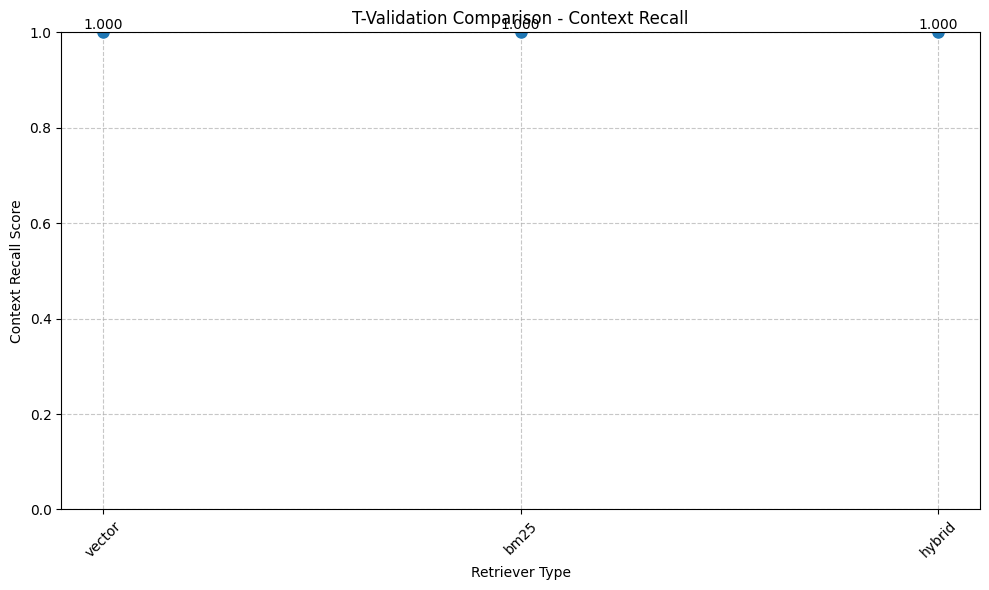

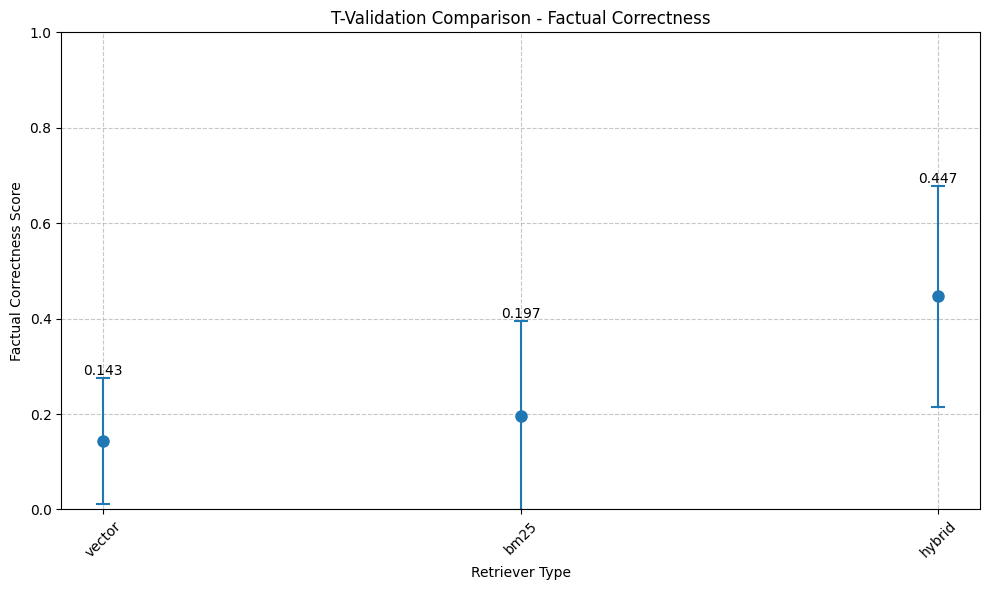

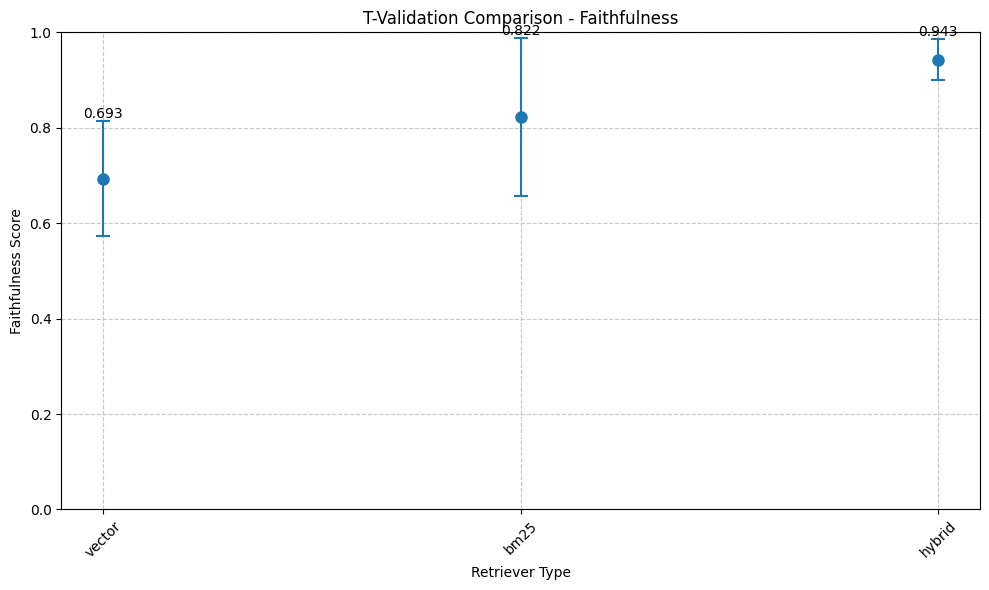

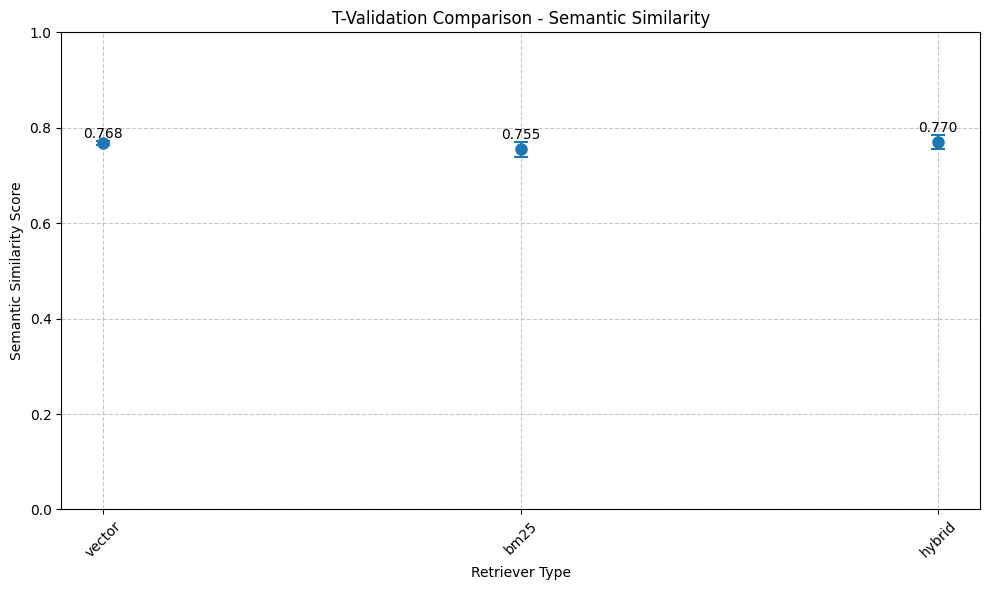

In [11]:
# Run evaluation
results = run_evaluation(n_samples=15, n_runs=3)

# Print results
for retriever_name, result in results.items():
    if result and result.get("results"):
        print(f"\nResults for {retriever_name}:")
        df = result["results"].to_pandas()
        print(df)